In [1]:
%load_ext autoreload
%autoreload 2

from imports import *
from dynamics import *
from model import *

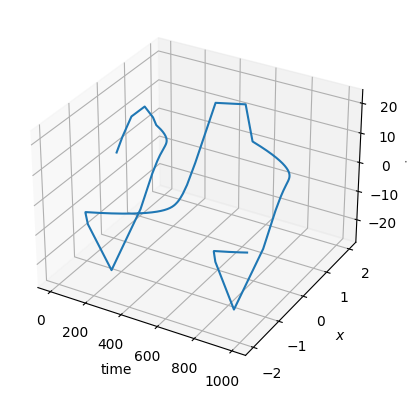

In [2]:
data, dt = vdp_oscillator(dim=1, mu=20, seed=90)

plot_3d(data.cpu().numpy())

In [3]:
def loss_fn(model, batch, num_negative_samples):
    min_difference = model(batch[1:, :]) - model(batch[:-1, :])

    '''
    negative samples: previous `num_negative_samples` in the trajectory given current x_t (i.e. x_{t - num_negative_samples} ... x_{t-1})
    '''
    negative_losses = []
    num_negative_samples_per_element = []
    
    for i in range(batch.shape[0]-1):
        num_samples = min(i, num_negative_samples)

        num_negative_samples_per_element.append(num_samples if num_samples else 1)

        if num_samples:
            # E_x_tp1_negative - E_x_t
            max_difference = model(batch[np.random.choice(i, size=(num_samples,), replace=False), :]) - model(batch[i, :].unsqueeze(0)).repeat(num_samples)
            
            negative_loss = torch.sum(
                torch.maximum(torch.zeros_like(max_difference).cuda(), -max_difference)**2 + \
                torch.minimum(torch.zeros_like(max_difference).cuda(), -max_difference/10)
            )

            negative_losses.append(negative_loss)

    '''
    positive term loss
    '''
    # E_x_tp1_positive - E_x_t
    positive_loss = 50 * torch.Tensor(num_negative_samples_per_element).cuda() * \
                    torch.maximum(torch.zeros_like(min_difference).cuda(), min_difference)**2

    return torch.mean(positive_loss) + sum(negative_losses)/len(negative_losses)


def plot_energy_along_trajectory(model, trajectory):
    with torch.no_grad():
        E_x_t = []

        for x_t in trajectory:
            E_x_t.append(model(x_t.unsqueeze(0)).squeeze().detach().cpu().item())

    plt.plot(E_x_t)
    plt.title("energy along trajectory")

    plt.show()


def plot_energy_landscape(model):
    X = torch.linspace(-10, 10, steps=500)
    Y = torch.linspace(-10, 10, steps=500)

    energy_manifold = model(torch.cartesian_prod(X, Y).cuda()).reshape(X.shape[0], Y.shape[0]).detach().cpu().numpy()

    X, Y = np.meshgrid(X.numpy(), Y.numpy())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    surface = ax.plot_surface(X, Y, energy_manifold, cmap='viridis', edgecolor='k', linewidth=0.5, facecolor=(1,1,1,0.2))

    fig.colorbar(surface, pad=0.1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$energy$')
    ax.set_title('energy landscape')
    
    plt.show()


def predict(model, data, dt):
    gradients = []
    errors = []
    predicted = []

    x_t = data[0, :]

    for i in range(data.shape[0]-1):
        x_t.requires_grad = True

        E_x_t = model(x_t.unsqueeze(0))
        E_x_t.backward(torch.ones_like(E_x_t).cuda())

        gradients.append(x_t.grad)

        x_tp1_pred = x_t - dt * gradients[-1]

        predicted.append(x_tp1_pred.detach().cpu())
        errors.append(torch.norm(x_tp1_pred.detach() - data[i + 1, :]).cpu().item())

        if (i % 1) == 0:
            x_t = data[i, :]
        else:
            x_t = deepcopy(x_tp1_pred.detach())

    predicted = np.array(torch.stack(predicted))
    errors = np.array(errors)

    plot_3d_trajectory(data.cpu().numpy(), predicted)
    
    return errors, gradients


def generate_batch(x, bs):
    i = np.random.randint(0, x.shape[0] - bs + 1, size=(1,)).item()

    return x[i : i + bs, :]


def epoch(iterations, model, optimizer, data, bs, num_negative_samples):
    losses = []

    for i in range(iterations):
        batch = generate_batch(data, bs=bs)

        optimizer.zero_grad()

        loss = loss_fn(model, batch, num_negative_samples=num_negative_samples)

        loss.backward()

        optimizer.step()

        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

  1%|          | 1/100 [00:04<07:58,  4.83s/it]

10207.0646484375


  2%|▏         | 2/100 [00:09<07:37,  4.66s/it]

6497.078637695313


  3%|▎         | 3/100 [00:13<07:28,  4.62s/it]

3021.0634887695314


  4%|▍         | 4/100 [00:18<07:24,  4.63s/it]

2256.8039794921874


  5%|▌         | 5/100 [00:23<07:16,  4.60s/it]

1427.4310668945313


  6%|▌         | 6/100 [00:27<07:10,  4.57s/it]

951.5816955566406


  7%|▋         | 7/100 [00:32<07:03,  4.55s/it]

617.9448028564453


  8%|▊         | 8/100 [00:36<07:01,  4.58s/it]

423.7961730957031


  9%|▉         | 9/100 [00:41<06:55,  4.57s/it]

275.95859375


 10%|█         | 10/100 [00:45<06:51,  4.57s/it]

251.2359375


 11%|█         | 11/100 [00:50<06:47,  4.58s/it]

207.65084228515624


 12%|█▏        | 12/100 [00:55<06:42,  4.58s/it]

228.32064208984374


 13%|█▎        | 13/100 [00:59<06:39,  4.59s/it]

121.12578887939453


 14%|█▍        | 14/100 [01:04<06:36,  4.61s/it]

168.5565399169922


 15%|█▌        | 15/100 [01:08<06:31,  4.60s/it]

107.13974304199219


 16%|█▌        | 16/100 [01:13<06:27,  4.61s/it]

130.46934967041017


 17%|█▋        | 17/100 [01:18<06:21,  4.60s/it]

62.13550796508789


 18%|█▊        | 18/100 [01:22<06:17,  4.61s/it]

75.01042709350585


 19%|█▉        | 19/100 [01:27<06:13,  4.61s/it]

50.90014495849609


 20%|██        | 20/100 [01:32<06:09,  4.62s/it]

57.81809921264649


 21%|██        | 21/100 [01:36<06:06,  4.64s/it]

38.68250427246094


 22%|██▏       | 22/100 [01:41<06:01,  4.64s/it]

49.34636764526367


 23%|██▎       | 23/100 [01:46<05:58,  4.65s/it]

30.5331974029541


 24%|██▍       | 24/100 [01:50<05:53,  4.65s/it]

36.78045997619629


 25%|██▌       | 25/100 [01:55<05:49,  4.66s/it]

15.197881698608398


 26%|██▌       | 26/100 [02:00<05:44,  4.65s/it]

17.868353652954102


 27%|██▋       | 27/100 [02:04<05:38,  4.64s/it]

13.308666801452636


 28%|██▊       | 28/100 [02:09<05:34,  4.64s/it]

13.031189346313477


 29%|██▉       | 29/100 [02:13<05:29,  4.64s/it]

4.45986704826355


 30%|███       | 30/100 [02:18<05:24,  4.64s/it]

9.222750282287597


 31%|███       | 31/100 [02:23<05:20,  4.64s/it]

3.500468921661377


 32%|███▏      | 32/100 [02:27<05:15,  4.64s/it]

6.234898471832276


 33%|███▎      | 33/100 [02:32<05:10,  4.64s/it]

2.5911173224449158


 34%|███▍      | 34/100 [02:37<05:06,  4.65s/it]

3.497002458572388


 35%|███▌      | 35/100 [02:41<05:01,  4.64s/it]

0.15817315578460694


 36%|███▌      | 36/100 [02:46<04:57,  4.64s/it]

3.200428533554077


 37%|███▋      | 37/100 [02:50<04:51,  4.63s/it]

-0.5765417516231537


 38%|███▊      | 38/100 [02:55<04:47,  4.63s/it]

1.0577007055282592


 39%|███▉      | 39/100 [03:00<04:42,  4.63s/it]

0.5423863887786865


 40%|████      | 40/100 [03:04<04:37,  4.63s/it]

2.3558210372924804


 41%|████      | 41/100 [03:09<04:33,  4.63s/it]

-0.8465903520584106


 42%|████▏     | 42/100 [03:14<04:28,  4.63s/it]

2.1140017747879027


 43%|████▎     | 43/100 [03:18<04:23,  4.63s/it]

0.050875681638717654


 44%|████▍     | 44/100 [03:23<04:20,  4.65s/it]

0.9165355205535889


 45%|████▌     | 45/100 [03:28<04:15,  4.64s/it]

0.387599778175354


 46%|████▌     | 46/100 [03:32<04:10,  4.65s/it]

0.652503490447998


 47%|████▋     | 47/100 [03:37<04:06,  4.64s/it]

0.0765598624944687


 48%|████▊     | 48/100 [03:42<04:01,  4.64s/it]

0.644243323802948


 49%|████▉     | 49/100 [03:46<03:56,  4.63s/it]

0.09849298596382142


 50%|█████     | 50/100 [03:51<03:51,  4.63s/it]

0.6528886973857879


 51%|█████     | 51/100 [03:55<03:46,  4.62s/it]

-0.12325878441333771


 52%|█████▏    | 52/100 [04:00<03:41,  4.61s/it]

0.3720925092697144


 53%|█████▎    | 53/100 [04:05<03:37,  4.62s/it]

0.12227460145950317


 54%|█████▍    | 54/100 [04:09<03:32,  4.62s/it]

0.01350739598274231


 55%|█████▌    | 55/100 [04:14<03:27,  4.62s/it]

-0.17945128083229064


 56%|█████▌    | 56/100 [04:18<03:22,  4.61s/it]

0.7454907536506653


 57%|█████▋    | 57/100 [04:23<03:18,  4.61s/it]

-0.15653408020734788


 58%|█████▊    | 58/100 [04:28<03:13,  4.61s/it]

-0.24920433163642883


 59%|█████▉    | 59/100 [04:32<03:08,  4.61s/it]

-0.12552644610404967


 60%|██████    | 60/100 [04:37<03:05,  4.63s/it]

0.16460758447647095


 61%|██████    | 61/100 [04:42<03:00,  4.63s/it]

-0.24853564500808717


 62%|██████▏   | 62/100 [04:46<02:56,  4.64s/it]

-0.08384045660495758


 63%|██████▎   | 63/100 [04:51<02:51,  4.63s/it]

-0.525383411347866


 64%|██████▍   | 64/100 [04:56<02:47,  4.65s/it]

0.3539650559425354


 65%|██████▌   | 65/100 [05:00<02:42,  4.65s/it]

-0.09907286316156387


 66%|██████▌   | 66/100 [05:05<02:38,  4.65s/it]

-0.3003497213125229


 67%|██████▋   | 67/100 [05:09<02:33,  4.65s/it]

-0.0010261133313179017


 68%|██████▊   | 68/100 [05:14<02:29,  4.67s/it]

-0.08175620287656785


 69%|██████▉   | 69/100 [05:19<02:24,  4.66s/it]

-0.4393399626016617


 70%|███████   | 70/100 [05:23<02:19,  4.66s/it]

0.20952598601579667


 71%|███████   | 71/100 [05:28<02:14,  4.65s/it]

-0.3317696452140808


 72%|███████▏  | 72/100 [05:33<02:10,  4.66s/it]

-0.30149497389793395


 73%|███████▎  | 73/100 [05:37<02:05,  4.65s/it]

-0.5478221356868744


 74%|███████▍  | 74/100 [05:42<02:01,  4.66s/it]

0.09575480818748475


 75%|███████▌  | 75/100 [05:47<01:56,  4.66s/it]

-0.20646890997886658


 76%|███████▌  | 76/100 [05:51<01:51,  4.66s/it]

-0.5664105653762818


 77%|███████▋  | 77/100 [05:56<01:47,  4.66s/it]

-0.012315177917480468


 78%|███████▊  | 78/100 [06:01<01:42,  4.66s/it]

-0.40515436232089996


 79%|███████▉  | 79/100 [06:05<01:38,  4.67s/it]

-0.26756579875946046


 80%|████████  | 80/100 [06:10<01:33,  4.67s/it]

-0.12522993683815004


 81%|████████  | 81/100 [06:15<01:28,  4.68s/it]

-0.4395677149295807


 82%|████████▏ | 82/100 [06:19<01:24,  4.67s/it]

-0.43365276157855986


 83%|████████▎ | 83/100 [06:24<01:19,  4.67s/it]

-0.35591763257980347


 84%|████████▍ | 84/100 [06:29<01:14,  4.68s/it]

-0.20421355962753296


 85%|████████▌ | 85/100 [06:33<01:10,  4.67s/it]

-0.6134905204176903


 86%|████████▌ | 86/100 [06:38<01:05,  4.68s/it]

0.04642841964960098


 87%|████████▋ | 87/100 [06:43<01:00,  4.67s/it]

-0.19638139009475708


 88%|████████▊ | 88/100 [06:47<00:55,  4.66s/it]

-0.41731542348861694


 89%|████████▉ | 89/100 [06:52<00:51,  4.66s/it]

-0.30652225464582444


 90%|█████████ | 90/100 [06:57<00:46,  4.66s/it]

-0.46939427703619


 91%|█████████ | 91/100 [07:01<00:41,  4.65s/it]

-1.324432897567749


 92%|█████████▏| 92/100 [07:06<00:37,  4.64s/it]

-0.7741531610488892


 93%|█████████▎| 93/100 [07:11<00:32,  4.62s/it]

0.9651876568794251


 94%|█████████▍| 94/100 [07:15<00:27,  4.51s/it]

-0.09487643241882324


 95%|█████████▌| 95/100 [07:19<00:22,  4.41s/it]

-1.0273436427116394


 96%|█████████▌| 96/100 [07:23<00:17,  4.34s/it]

-0.01950990706682205


 97%|█████████▋| 97/100 [07:27<00:12,  4.28s/it]

-0.8541714578866959


 98%|█████████▊| 98/100 [07:31<00:08,  4.24s/it]

-0.6809481978416443


 99%|█████████▉| 99/100 [07:36<00:04,  4.23s/it]

-0.9762863278388977


100%|██████████| 100/100 [07:40<00:00,  4.60s/it]

-0.5463141083717347


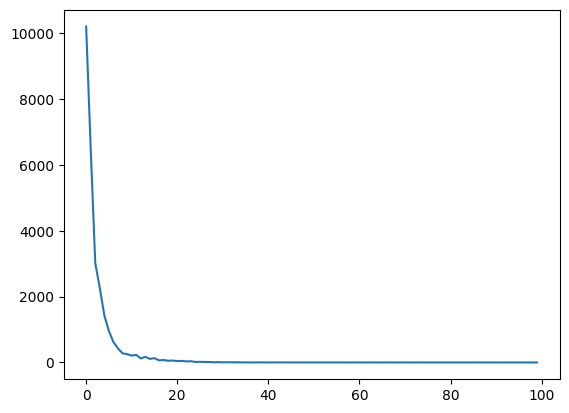

In [4]:
dim = 1

model = EBM(dim * 2).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

losses = []

seeds = np.arange(10)

for e in tqdm(range(100)):
    data, dt = vdp_oscillator(dim=dim, mu=20, seed=seeds[torch.randint(0, len(seeds), size=(1,)).item()])

    N = data.shape[0]
    bs = int(0.5 * N)

    loss = epoch(iterations=5, model=model, optimizer=optimizer, data=data, bs=bs, num_negative_samples=int(bs * 0.5))
    losses.append(loss)
    print(loss)

plt.plot(losses)

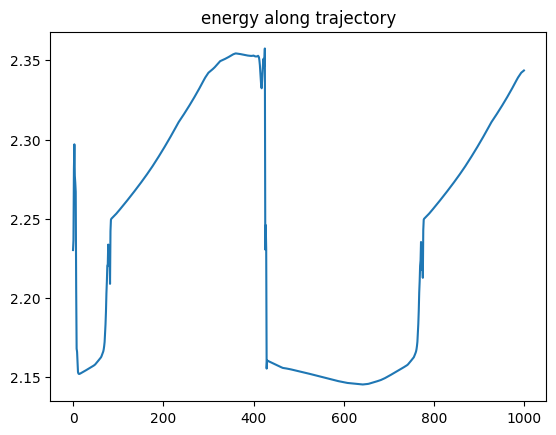

In [5]:
data, dt = vdp_oscillator(dim=dim, mu=20, seed=seeds[torch.randint(0, len(seeds), size=(1,)).item()])

plot_energy_along_trajectory(model, data)

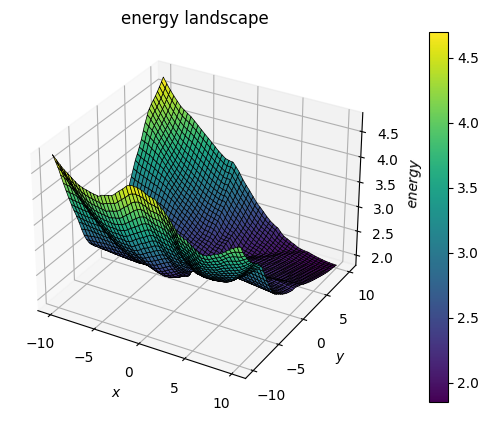

In [6]:
plot_energy_landscape(model)

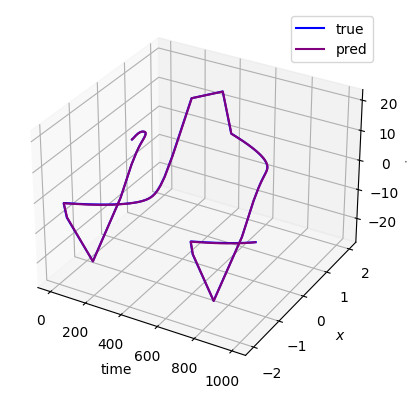

In [7]:
data, dt = vdp_oscillator(dim=dim, mu=20, seed=seeds[torch.randint(0, len(seeds), size=(1,)).item()])

errors, gradients = predict(model, data, dt)